# Gridpoint env precursor analysis


* So far using CAPE/TCWV, 4x shear
  * low, mid, high, deep.
* 1d/2d histograms
* Filter on fractional growth rate values.
* My initial impressions are that neither CAPE nor TCWV are strongly correlated with MCS area, or growth rates.
* CAPE does seem to have some link to growth, when subsetting CAPE to growing MCSs
* Subset tracks to tropics/equator
* Shear does not seem to be a good predictor of growth/decay
* CAPE vs duration/area does not show anything that notable yet.

Work so far:

* 19/8/22: Initial work. Basic match up of tracks data and era5 tracks linked data.
* 31/8/22: Intial shear analysis.
* 9/9/22: Restructure code and do tropics/equator subsetting/stratification.
* 9/9/22: Add in CAPE vs duration, CAPE vs area 2D hists.
* 15/5/23: Plan is to supercede this with similar analysis but based on MCS masks.

In [1]:
from pathlib import Path

import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS

from remake import load_remake

In [2]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])
ntracks = len(tracks.dstracks.tracks)

In [3]:
teep = load_remake('../../remakefiles/track_era5_env_precursor.py')

In [4]:
task_shear = teep.CombineTrackERA5EnvPrecursor.tasks.filter(year=2019, datatype='shear')[0]
task_2D = teep.CombineTrackERA5EnvPrecursor.tasks.filter(year=2019, datatype='2D')[0]

In [5]:
path_shear = task_shear.outputs['track_era5_data']
path_2D = task_2D.outputs['track_era5_data']
for path in [path_shear, path_2D]:
    print(path.exists())

True
True


In [6]:
# Produced by remakefiles/track_era5_env_precursor.py
track_era5 = xr.open_dataset(path_2D)
track_era5uv = xr.open_dataset(path_shear)

In [7]:
track_era5

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
Data variables:
    cape     (tracks, times) float32 ...
    tcwv     (tracks, times) float32 ...

In [8]:
track_era5uv

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400, level: 4)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
  * level    (level) int64 133 111 96 74
Data variables:
    u        (tracks, times, level) float64 ...
    v        (tracks, times, level) float64 ...

In [9]:
mask = ~np.isnan(track_era5.cape)
tmask = ~np.isnan(tracks.dstracks.area)
(mask.values == tmask.values).all()

True

# Plot some basic data

* Histograms of CAPE/TCWV conditional on where an MCS is.

In [10]:
def plot_hist(title, units, data, mask, bins):
    plt.figure(title)
    plt.title(title)
    plt.hist(data[mask], bins=bins, density=True)
    plt.xlabel(units)
    

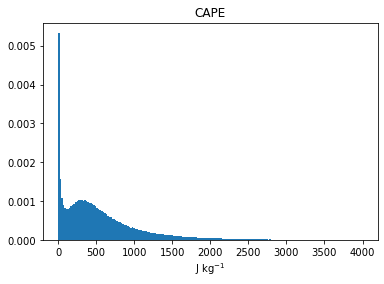

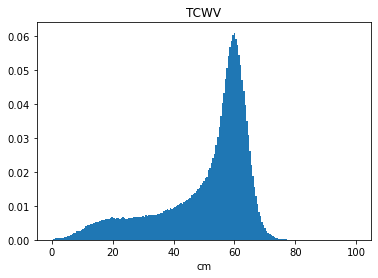

In [11]:
plot_hist('CAPE', 'J kg$^{-1}$', track_era5.cape.values, mask, bins=np.linspace(0, 4000, 200))
plot_hist('TCWV', 'cm', track_era5.tcwv.values, mask, bins=np.linspace(0, 100, 200))


Large spike at CAPE=0

In [12]:
# Subset some tracks based on their lat.

tracks.dstracks.meanlat.load()

# Perhaps problem I am seeing below with tropical uv data is due to this?
# Try setting this to true as per: https://docs.dask.org/en/stable/array-slicing.html
dask.config.set({"array.slicing.split_large_chunks": True})
# This suppresses a warning about chunk sizes.
# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
if True:
    tropical_mask = ((tracks.dstracks.meanlat.values > -20) & (tracks.dstracks.meanlat.values < 20)).any(axis=1)
    eq_mask = ((tracks.dstracks.meanlat.values > -5) & (tracks.dstracks.meanlat.values < 5)).any(axis=1)
    dstracks_tropical = tracks.dstracks.isel(tracks=tropical_mask)
    dstracks_eq = tracks.dstracks.isel(tracks=eq_mask)
    
    track_era5_tropical = track_era5.sel(tracks=tropical_mask)
    track_era5_eq = track_era5.sel(tracks=eq_mask)
    # These are not usable - no point in creating them.
    # Trying to access their fields just leads to a kernel hang.
    # track_era5uv_tropical = track_era5uv.sel(tracks=tropical_mask)
    # track_era5uv_eq = track_era5uv.sel(tracks=eq_mask)

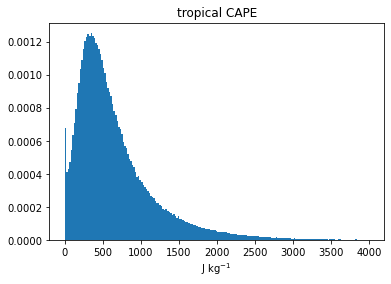

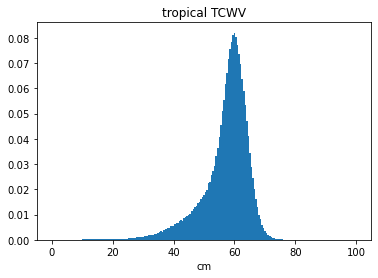

In [13]:
mask = ~np.isnan(track_era5_tropical.cape)

plot_hist('tropical CAPE', 'J kg$^{-1}$', track_era5_tropical.cape.values, mask, bins=np.linspace(0, 4000, 200))
plot_hist('tropical TCWV', 'cm', track_era5_tropical.tcwv.values, mask, bins=np.linspace(0, 100, 200))

# Perform growth/stable/decay analysis

Idea, use fractional area growth, $\frac{1}{A}\frac{dA}{dt}$ -> $\frac{1}{A^{n+1}}\frac{A^{n+1} - A^n}{\Delta t}$ to stratify environmental conditions where MCSs present.

In [14]:
# What to use? In Chakraborty et al. (2016) supplement they use 0.1. However, this seems to 
# not pick up *any* relationship. Using a higher values finds a relationship for CAPE.
# E.g. using 0.5.
growth_thresh = 0.5

In [15]:
def calc_frac_growth(dstracks):
    mask = ~np.isnan(dstracks.area)

    dt = 1
    fractional_area_growth = dstracks.area.values.copy()
    fractional_area_growth[:, 1:] = (1 / dstracks.area[:, 1:].values) * ((dstracks.area[:, 1:].values - dstracks.area[:, :-1].values) / dt)
    area_mask = mask.copy()
    area_mask[:, 0] = False
    return fractional_area_growth, area_mask

def calc_growth_masks(fractional_area_growth, thresh=0.5):
    growth_mask = fractional_area_growth >= thresh
    stable_mask = (fractional_area_growth > -thresh) & (fractional_area_growth < thresh)
    decay_mask = fractional_area_growth <= thresh
    
    return growth_mask, stable_mask, decay_mask

In [16]:
def plot_growth_hists(title, units, data, mask, growth_mask, stable_mask, decay_mask, bins):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
        plot_data = data[m & mask]
        mean = plot_data.mean()
        p = plt.hist(plot_data, bins=bins, histtype='step', density=True, label=l, color=c);
        plt.axvline(x=mean, color=c)
        print(title, l, mean)
    plt.xlabel(units)
    plt.legend()

CAPE growth 712.5151
CAPE stable 542.7123
CAPE decay 542.5304
TCWV growth 50.14701
TCWV stable 50.84009
TCWV decay 50.68083


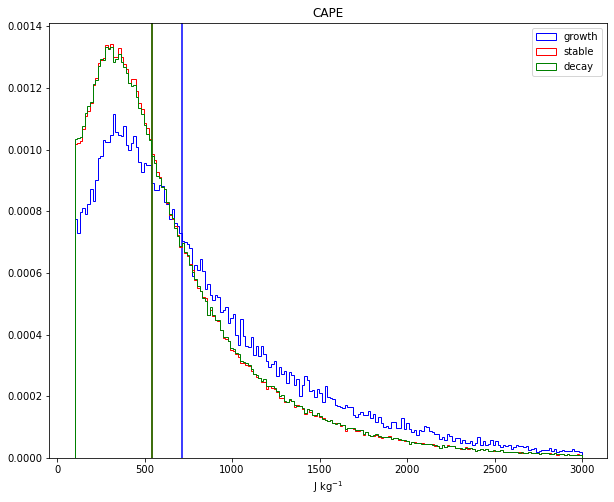

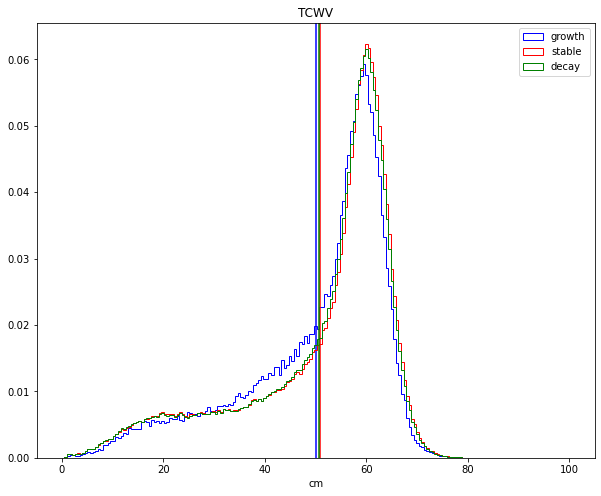

In [17]:
mask = ~np.isnan(track_era5.cape)

fg, fg_mask = calc_frac_growth(tracks.dstracks)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_growth_hists('CAPE', 'J kg$^{-1}$', track_era5.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(100, 3000, 200))
plot_growth_hists('TCWV', 'cm', track_era5.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

tropical CAPE growth 798.8446
tropical CAPE stable 645.08167
tropical CAPE decay 641.21466
tropical TCWV growth 55.47926
tropical TCWV stable 57.60395
tropical TCWV decay 57.274914


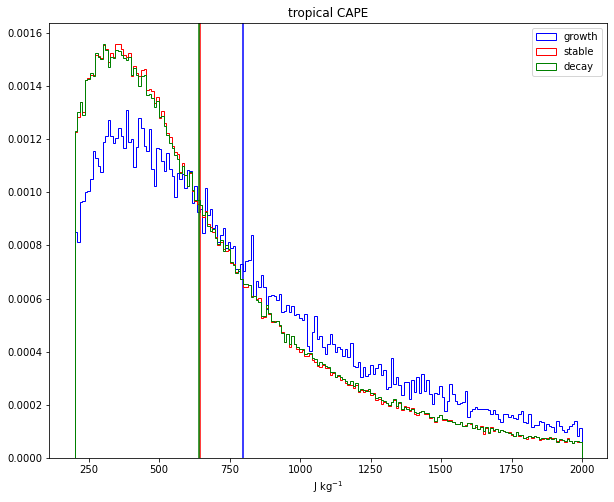

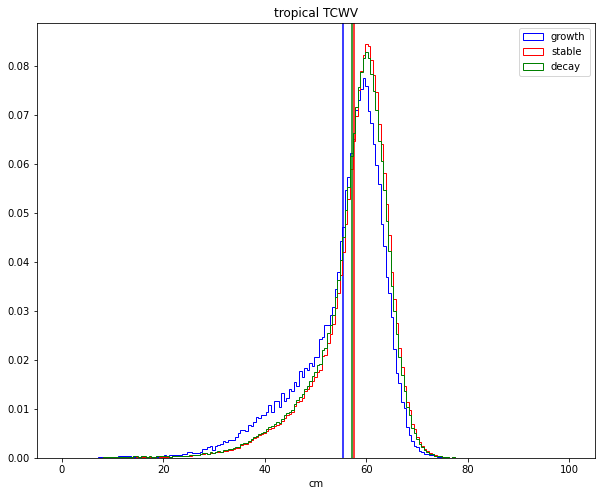

In [18]:
mask = ~np.isnan(track_era5_tropical.cape)
fg, fg_mask = calc_frac_growth(dstracks_tropical)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_growth_hists('tropical CAPE', 'J kg$^{-1}$', track_era5_tropical.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(200, 2000, 200))
plot_growth_hists('tropical TCWV', 'cm', track_era5_tropical.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

equator CAPE growth 787.54724
equator CAPE stable 632.32465
equator CAPE decay 626.04663
equator TCWV growth 55.977882
equator TCWV stable 57.875908
equator TCWV decay 57.606552


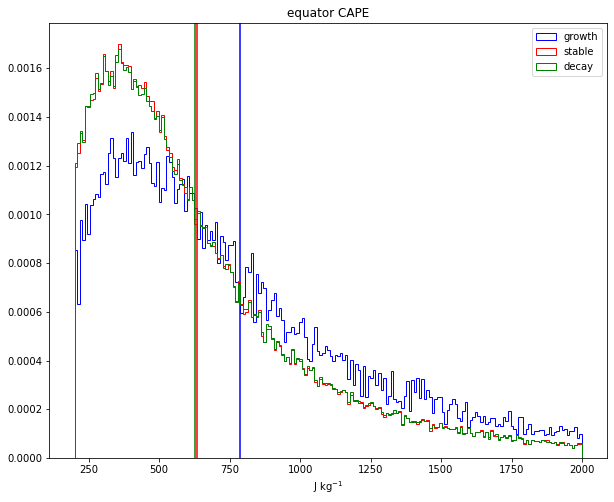

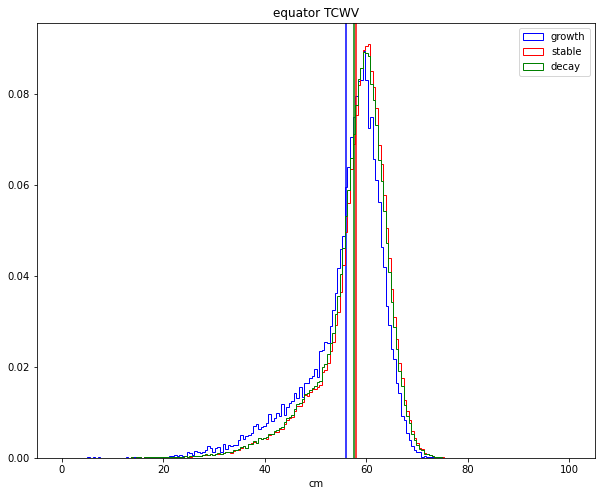

In [19]:
mask = ~np.isnan(track_era5_eq.cape)
fg, fg_mask = calc_frac_growth(dstracks_eq)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_growth_hists('equator CAPE', 'J kg$^{-1}$', track_era5_eq.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(200, 2000, 200))
plot_growth_hists('equator TCWV', 'cm', track_era5_eq.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

In [20]:
def plot_shear(title, shear, mask, growth_mask, stable_mask, decay_mask, n=4):
    titles = {0: 'lls', 1: 'mls', 2: 'hls', 3: 'ds'}
    for i in range(n):
        plot_growth_hists(title + ' ' + titles[i], 'm s$^{-1}$', shear[:, :, i], mask, growth_mask, stable_mask, decay_mask, bins=np.linspace(0, 40, 200))
        
track_era5uv

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400, level: 4)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
  * level    (level) int64 133 111 96 74
Data variables:
    u        (tracks, times, level) float64 ...
    v        (tracks, times, level) float64 ...

In [21]:
def calc_shear(track_era5uv):
    track_era5uv.u.load()
    track_era5uv.v.load()
    u = track_era5uv.u.values
    v = track_era5uv.v.values
    # Calc LLS, MLS, HLS, DS in one line.
    # LLS = shear[:, :, 0]
    # MLS = shear[:, :, 1]
    # HLS = shear[:, :, 2]
    # DS = shear[:, :, 3]
    shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
    return shear
    # lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [22]:
shear = calc_shear(track_era5uv)

full lls growth 5.384002720360913
full lls stable 5.974353083967974
full lls decay 5.938137376571411
full mls growth 6.618838844711296
full mls stable 7.218920000993932
full mls decay 7.146636964051767
full hls growth 12.168861818156156
full hls stable 12.496089029253378
full hls decay 12.417653785656285
full ds growth 16.720428414505147
full ds stable 17.99090925038603
full ds decay 17.752738719573845


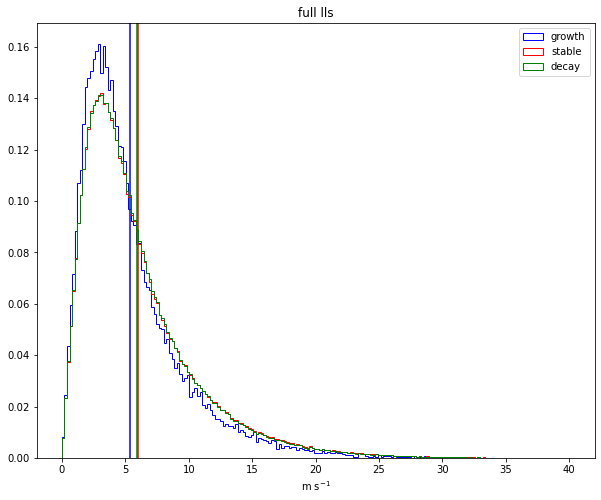

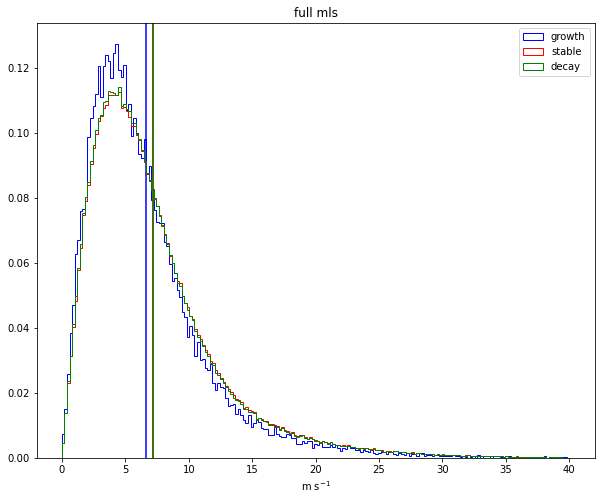

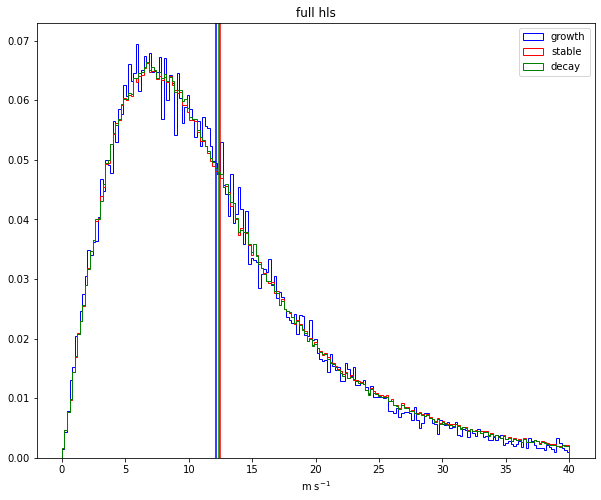

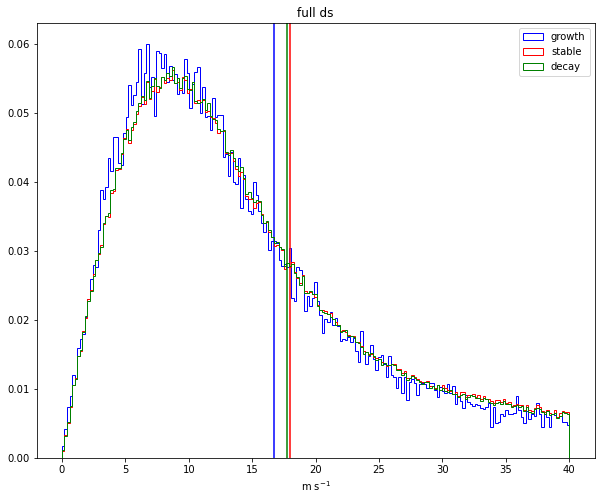

In [23]:
fg, fg_mask = calc_frac_growth(tracks.dstracks)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_shear('full', shear, fg_mask, growth_mask, stable_mask, decay_mask)

In [24]:
fg, fg_mask = calc_frac_growth(tracks.dstracks)
fg_mask[~tropical_mask] = False
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)

print(growth_mask.shape, fg_mask.shape, tropical_mask.shape)


(32843, 400) (32843, 400) (32843,)


tropical lls growth 4.2466967818587555
tropical lls stable 4.57181303408921
tropical lls decay 4.6006528398261946
tropical mls growth 5.457985438906553
tropical mls stable 5.838145063571313
tropical mls decay 5.817031181156611
tropical hls growth 10.450133589258284
tropical hls stable 10.09576942994996
tropical hls decay 10.128099660224159
tropical ds growth 11.933400390405666
tropical ds stable 12.063438261901675
tropical ds decay 12.058892919150189


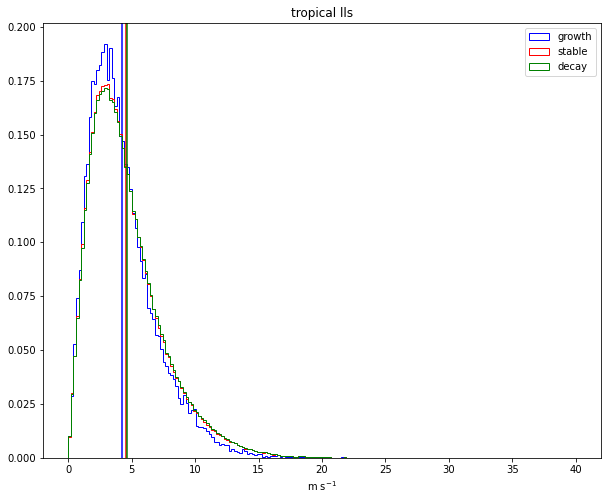

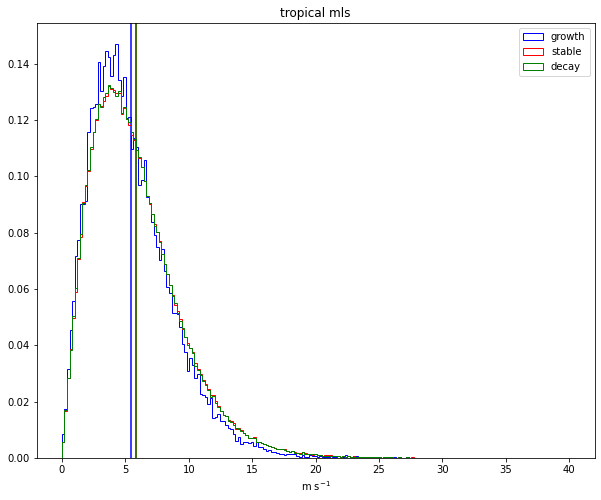

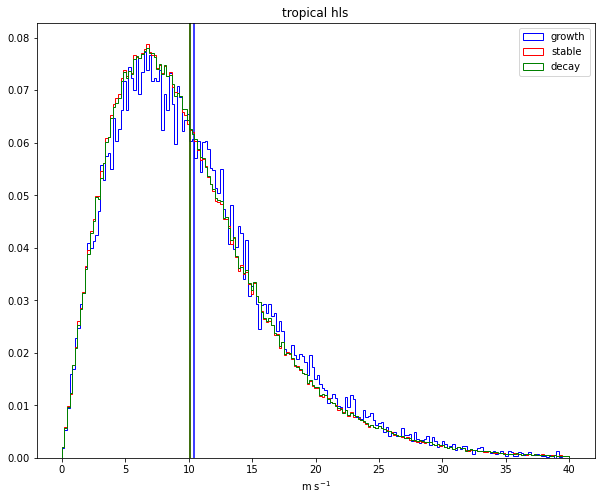

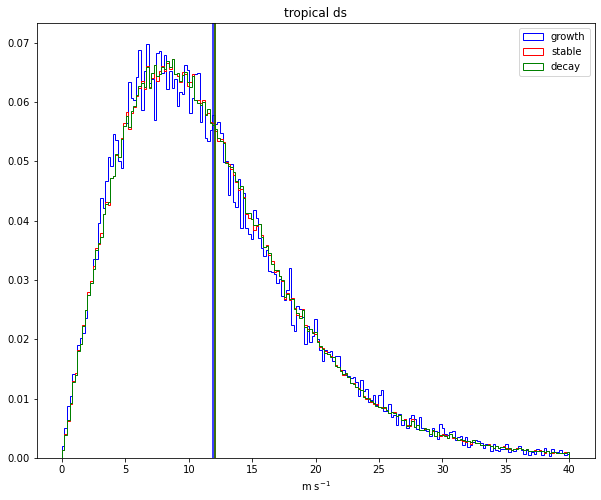

In [25]:
fg, fg_mask = calc_frac_growth(tracks.dstracks)
fg_mask[~tropical_mask] = False
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_shear('tropical', shear, fg_mask, growth_mask, stable_mask, decay_mask)

extratropical lls growth 8.558902324127287
extratropical lls stable 9.289580564564517
extratropical lls decay 9.168771070883823
extratropical mls growth 9.859473482541715
extratropical mls stable 10.482700609225505
extratropical mls decay 10.358239883085732
extratropical hls growth 16.966858019685336
extratropical hls stable 18.1697990231413
extratropical hls decay 17.947968715930575
extratropical ds growth 30.083880465892747
extratropical ds stable 32.00185654074024
extratropical ds decay 31.5059669533983


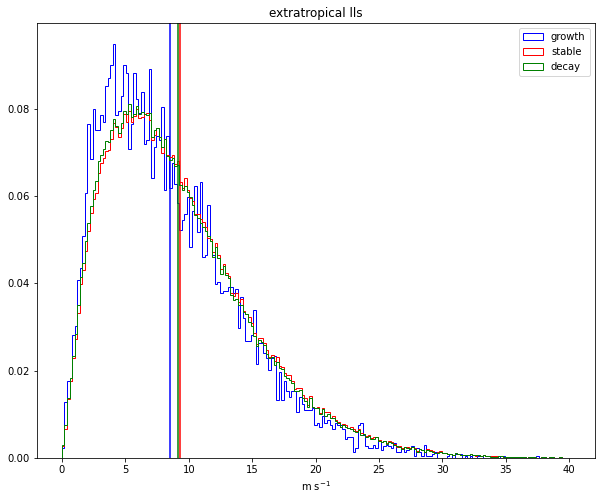

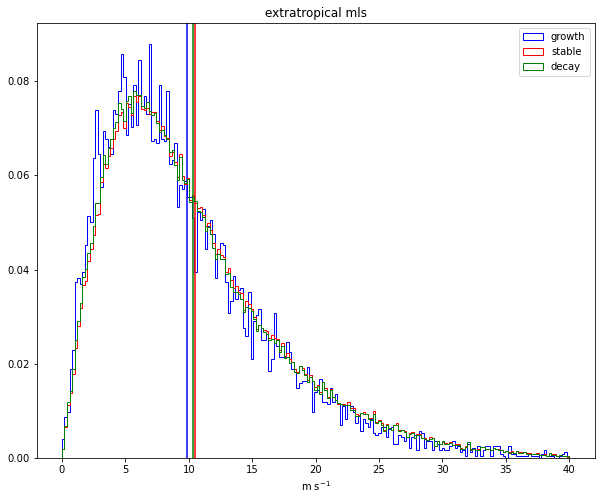

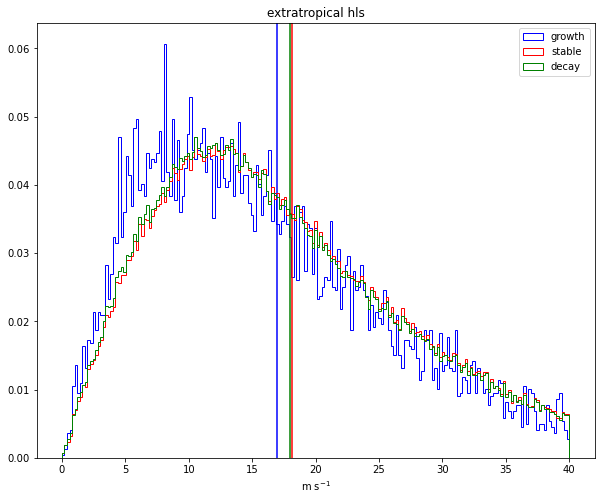

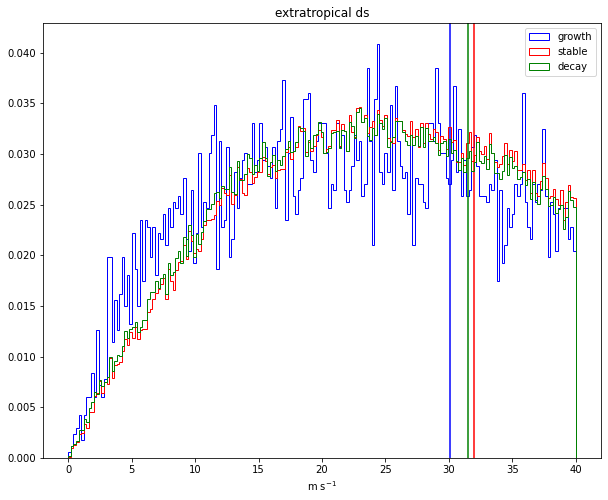

In [26]:
fg, fg_mask = calc_frac_growth(tracks.dstracks)
fg_mask[tropical_mask] = False
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_shear('extratropical', shear, fg_mask, growth_mask, stable_mask, decay_mask)

equatorial lls growth 4.150339999106947
equatorial lls stable 4.321965128439034
equatorial lls decay 4.357941347591367
equatorial mls growth 5.3269851806982755
equatorial mls stable 5.579920547199723
equatorial mls decay 5.576391173647917
equatorial hls growth 10.334179271821197
equatorial hls stable 9.725499263918097
equatorial hls decay 9.76094496704582
equatorial ds growth 11.10238513611855
equatorial ds stable 10.828286797845907
equatorial ds decay 10.837859727106617


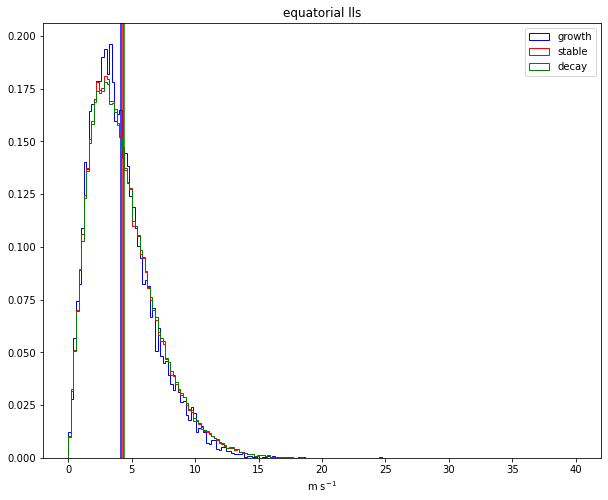

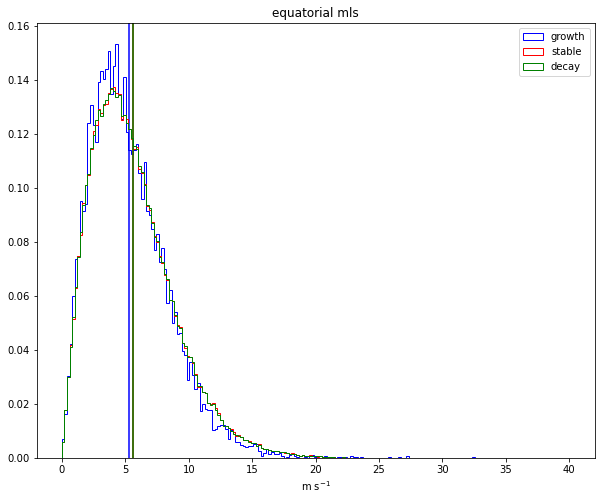

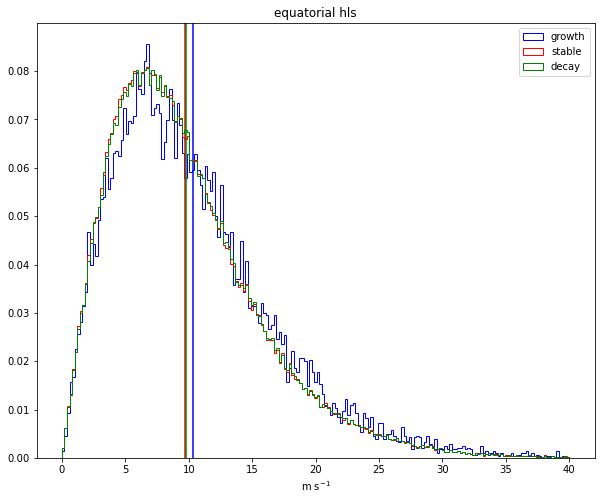

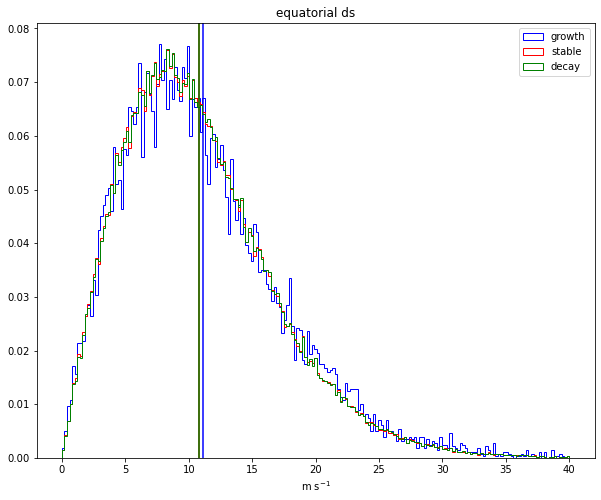

In [27]:
fg, fg_mask = calc_frac_growth(tracks.dstracks)
fg_mask[~eq_mask] = False
growth_mask, stable_mask, decay_mask = calc_growth_masks(fg, growth_thresh)
plot_shear('equatorial', shear, fg_mask, growth_mask, stable_mask, decay_mask)

In [28]:
# DOING IT LIKE THIS DOES NOT WORK!
# I suspect it is to do with how the data are chunked. I have a nicer way
# of doing it anyway - see above.

# DO NOT KNOW WHY THESE HAVE STOPPED WORKING!
# Cannot even get u values.
# u = track_era5uv_tropical.u.values
if False:
    fg, fg_mask = calc_frac_growth(dstracks_tropical)
    growth_mask, stable_mask, decay_mask = calc_growth_masks(fg)

    shear = calc_shear(track_era5uv_tropical)
    plot_shear('tropical', shear, fg_mask, growth_mask, stable_mask, decay_mask)

In [29]:
if False:
    fg, fg_mask = calc_frac_growth(dstracks_eq)
    growth_mask, stable_mask, decay_mask = calc_growth_masks(fg)

    shear = calc_shear(track_era5uv_eq)
    plot_shear('equatorial', shear, fg_mask, growth_mask, stable_mask, decay_mask)

# Growth given CAPE/TCWV/LLS

Switch round analysis: look at growth for given CAPE/TCWV ranges.

In [63]:
# Choose 4 CAPE bins for now: 0-500, 500-1000, 1000-1500, 1500-2000.
m1 = track_era5.cape.values <= 500
m2 = (track_era5.cape.values > 500) & (track_era5.cape.values <= 1000)
m3 = (track_era5.cape.values > 1000) & (track_era5.cape.values <= 1500)
m4 = (track_era5.cape.values > 1500) & (track_era5.cape.values <= 2000)

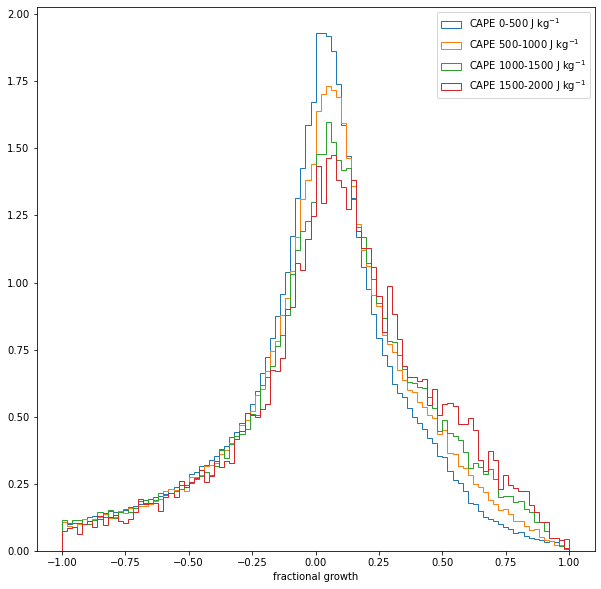

In [64]:
plt.figure(figsize=(10, 10))
for (m, l) in zip([m1, m2, m3, m4], ['0-500', '500-1000', '1000-1500', '1500-2000']):
    plt.hist(fg[m], bins=np.linspace(-1, 1, 101), density=True, histtype='step', label='CAPE ' + l + ' J kg$^{-1}$')
plt.xlabel('fractional growth')
plt.legend();

In [65]:
# Choose 4 TCWV bins.
m1 = track_era5.tcwv.values <= 20
m2 = (track_era5.tcwv.values > 20) & (track_era5.tcwv.values <= 40)
m3 = (track_era5.tcwv.values > 40) & (track_era5.tcwv.values <= 60)
m4 = (track_era5.tcwv.values > 60) & (track_era5.tcwv.values <= 80)

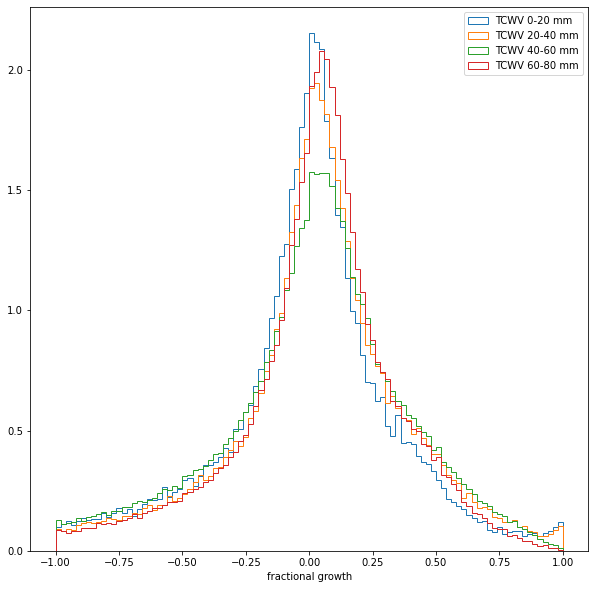

In [66]:
plt.figure(figsize=(10, 10))
for (m, l) in zip([m1, m2, m3, m4], ['0-20', '20-40', '40-60', '60-80']):
    plt.hist(fg[m], bins=np.linspace(-1, 1, 101), density=True, histtype='step', label='TCWV ' + l + ' mm')
plt.xlabel('fractional growth')
plt.legend();

In [67]:
# Choose 4 LLS bins.
lls = shear[:, :, 0]
m1 = lls <= 4
m2 = (lls > 4) & (lls <= 8)
m3 = (lls > 8) & (lls <= 12)
m4 = (lls > 12) & (lls <= 16)

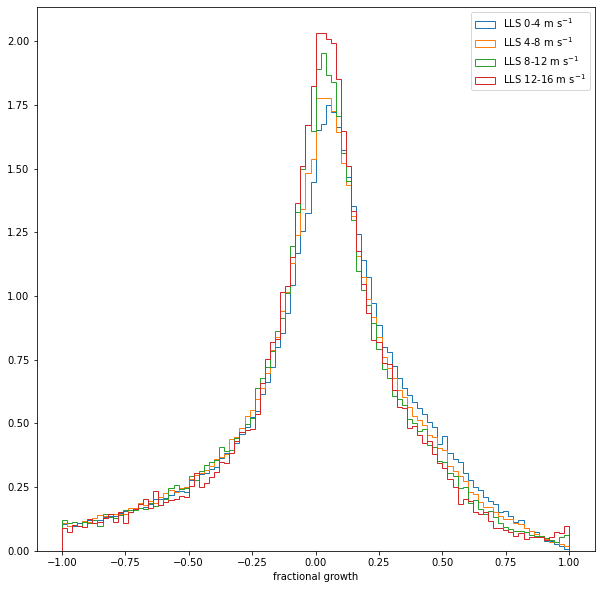

In [68]:
plt.figure(figsize=(10, 10))
for (m, l) in zip([m1, m2, m3, m4], ['0-4', '4-8', '8-12', '12-16']):
    plt.hist(fg[m], bins=np.linspace(-1, 1, 101), density=True, histtype='step', label='LLS ' + l + ' m s$^{-1}$')
plt.xlabel('fractional growth')
plt.legend();

# 2D histograms

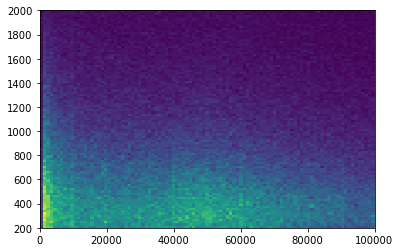

In [30]:
mask = ~np.isnan(track_era5.cape)

plt.hist2d(tracks.dstracks.area.values[mask], track_era5.cape.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(200, 2000, 100)));

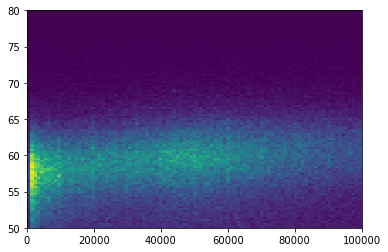

In [31]:
plt.hist2d(tracks.dstracks.area.values[mask], track_era5.tcwv.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(50, 80, 100)));

In [32]:
dt = 1
fractional_area_growth = tracks.dstracks.area.values.copy()
fractional_area_growth[:, 1:] = (1 / tracks.dstracks.area[:, 1:].values) * ((tracks.dstracks.area[:, 1:].values - tracks.dstracks.area[:, :-1].values) / dt)

In [33]:
area_mask = mask.copy()
area_mask[:, 0] = False

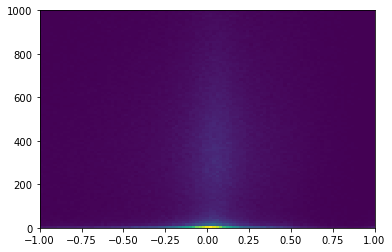

In [34]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(0, 1000, 100)));

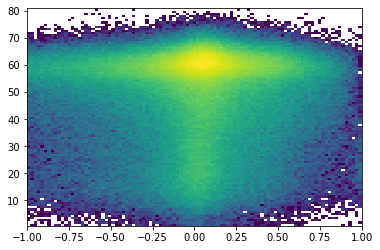

In [35]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.tcwv.values[area_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

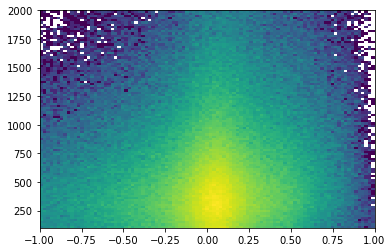

In [36]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

In [37]:
early_mask = area_mask.copy()
early_mask[:, 4:] = False

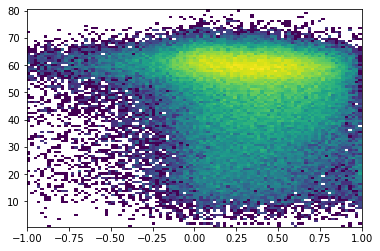

In [38]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.tcwv.values[early_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

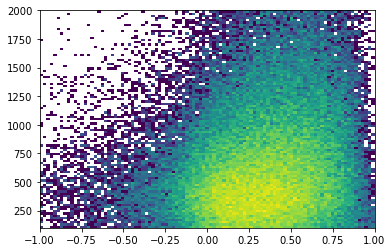

In [39]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

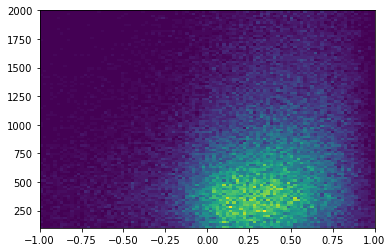

In [40]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)));

# Experimental

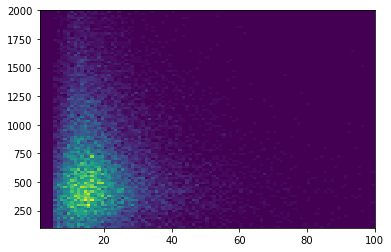

In [41]:
# mean CAPE vs duration.
plt.hist2d(tracks.dstracks.track_duration.values, np.nanmean(track_era5.cape.values, axis=1), bins=(np.linspace(1, 100, 100), np.linspace(100, 2000, 100)));

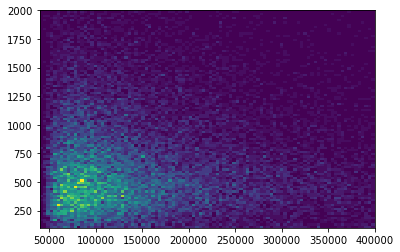

In [42]:
# mean CAPE vs max area.
plt.hist2d(np.nanmax(tracks.dstracks.area.values, axis=1), np.nanmean(track_era5.cape.values, axis=1), bins=(np.linspace(40000, 400000, 100), np.linspace(100, 2000, 100)));

# OLD CODE

In [43]:
raise Exception('No longer run!')
thresh = 0.1
growth_mask = fractional_area_growth >= 0.1
stable_mask = (fractional_area_growth > -0.1) & (fractional_area_growth < 0.1)
decay_mask = fractional_area_growth <= 0.1

Exception: No longer run!

In [ ]:
thresh = 0.1  # roughly equal numbers in each.
growth_mask = fractional_area_growth > thresh
decay_mask = fractional_area_growth < -thresh
stable_mask = (fractional_area_growth >= -thresh) & (fractional_area_growth <= thresh)
print(growth_mask.sum())
print(stable_mask.sum())
print(decay_mask.sum())

In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.cape.values[m & mask]
    mean = data[data > 100].mean()
    p = plt.hist(data, bins=np.linspace(100, 3000, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.tcwv.values[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 80, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


## Similar, but for shear at different levels.

In [ ]:
track_era5uv.level

In [ ]:
def calc_shear(track_era5uv):
    u = track_era5uv.u.values
    v = track_era5uv.v.values
    # Calc LLS, MLS, HLS, DS in one line.
    # LLS = shear[:, :, 0]
    # MLS = shear[:, :, 1]
    # HLS = shear[:, :, 2]
    # DS = shear[:, :, 3]
    shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
    return shear
    # lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [ ]:
def plot_shear(shear, mask, growth_mask, stable_mask, decay_mask, n=4):
    titles = {0: 'lls', 1: 'mls', 2: 'hls', 3: 'ds'}
    for i in range(n):
        sh = shear[:, :, i]
        plt.figure(figsize=(10, 8))
        plt.title(titles[i])
        for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
            data = sh[m & mask]
            mean = data.mean()
            p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
            plt.axvline(x=mean, color=c)
            print(mean)
        plt.legend()

In [ ]:
shear = calc_shear(track_era5uv)
plot_shear(shear, mask, growth_mask, stable_mask, decay_mask)

In [ ]:
# u = track_era5uv.u.values
# v = track_era5uv.v.values

In [ ]:
# u.shape

In [ ]:
# Calc LLS, MLS, HLS, DS in one line.
# LLS = shear[:, :, 0]
# MLS = shear[:, :, 1]
# HLS = shear[:, :, 2]
# DS = shear[:, :, 3]
# shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
# lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [ ]:
# for i in range(3):
#     print(np.sqrt((u[0, 0, i + 1] - u[0, 0, i])**2 + (v[0, 0, i + 1] - v[0, 0, i])**2))
# print(np.sqrt((u[0, 0, -1] - u[0, 0, 0])**2 + (v[0, 0, -1] - v[0, 0, 0])**2))

In [ ]:
# shear[0, 0, :]

In [ ]:
mask = ~np.isnan(lls)

In [ ]:
plt.hist(lls[mask], bins=100);

In [ ]:
plt.hist(mls[mask], bins=100);

In [ ]:
plt.hist(hls[mask], bins=100);

In [ ]:
plt.hist(ds[mask], bins=100);

In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = lls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = mls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = hls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = ds[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
tracks.dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    tropical_mask = ((tracks.dstracks.meanlat.values > -20) & (tracks.dstracks.meanlat.values < 20)).any(axis=1)
    eq_mask = ((tracks.dstracks.meanlat.values > -5) & (tracks.dstracks.meanlat.values < 5)).any(axis=1)
    dstracks_tropical = tracks.dstracks.isel(tracks=tropical_mask)
    dstracks_eq = tracks.dstracks.isel(tracks=eq_mask)
    
    track_era5uv_tropical = track_era5uv.sel(tracks=tropical_mask)
    track_era5uv_eq = track_era5uv.sel(tracks=eq_mask)
dstracks_tropical

In [ ]:
track_era5uv_eq

In [ ]:
def calc_frac_growth(dstracks):
    mask = ~np.isnan(dstracks.area)

    dt = 1
    fractional_area_growth = dstracks.area.values.copy()
    fractional_area_growth[:, 1:] = (1 / dstracks.area[:, 1:].values) * ((dstracks.area[:, 1:].values - dstracks.area[:, :-1].values) / dt)
    area_mask = mask.copy()
    area_mask[:, 0] = False
    return fractional_area_growth, area_mask

def calc_growth_masks(fractional_area_growth, thresh=0.1):
    growth_mask = fractional_area_growth >= 0.1
    stable_mask = (fractional_area_growth > -0.1) & (fractional_area_growth < 0.1)
    decay_mask = fractional_area_growth <= 0.1
    
    return growth_mask, stable_mask, decay_mask

In [ ]:
feg, feg_mask = calc_frac_growth(dstracks_tropical)
growth_mask, stable_mask, decay_mask = calc_growth_masks(feg)

shear = calc_shear(track_era5uv_tropical)
plot_shear(shear, feg_mask, growth_mask, stable_mask, decay_mask)

In [ ]:
feg, feg_mask = calc_frac_growth(dstracks_eq)
growth_mask, stable_mask, decay_mask = calc_growth_masks(feg)

shear = calc_shear(track_era5uv_eq)
plot_shear(shear, feg_mask, growth_mask, stable_mask, decay_mask)